# 02 NNの表現力と効用関数の検証
- 破産時にペナルティを与えるため，効用関数は収益や資産に対して，これらが負になった場合に大きくマイナスにするようにしたい．
ペナルティの無い場合，全額期初にキャッシュアウトして破産するのが最善方策になる場合などがあるためである．
しかし，このような不連続性及びレンジの大きい関数はNNで表現しにくいかもしれない．

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-bright')

---
## 1. 想定している効用関数
基本的には元の効用に相当する値をそのまま出力するが，負になった場合は大きくペナルティを与える仕様とする．

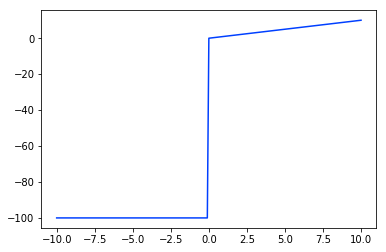

In [2]:
X = np.linspace(-10, 10, 201)
Y = X*1
Y[Y<0] = -100  # penalty term

plt.plot(X, Y)
plt.show()

---
## 2. ニューロンによる表現
先ず，この関数は，2つのニューロン（ReLU活性）で十分に表現可能である．

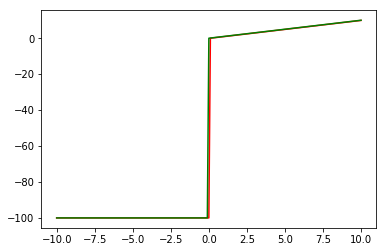

In [3]:
def relu(x):
    return np.maximum(x, 0)

Y_manual = (relu(X))*1000-100 - relu(X-0.1)*999

plt.plot(X, Y_manual, c='r')
plt.plot(X, Y, c='g')
plt.show()

---
## 3. 最低限のニューロンでの学習
ディープラーニングにおける通常のオプティマイザの元で，学習可能かどうかを検証する．

In [4]:
from keras.models import Model
from keras import layers
from keras import optimizers

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 7
Trainable params: 7
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
final loss =  16.165419499107188


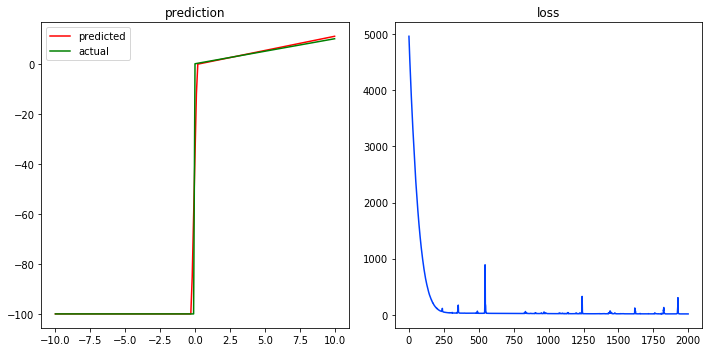

In [5]:
input_t = layers.Input(shape=(1,))
x = layers.Dense(2, activation='relu')(input_t)  # 2 newron
output_t = layers.Dense(1, activation='linear')(x)

model = Model([input_t], [output_t])

model.summary()

model.compile(optimizer=optimizers.adam(lr=0.1), loss='mse')
history = model.fit(X, Y, epochs=2000, verbose=0)
print('final loss = ', model.evaluate(X, Y, verbose=0))

def show_result(X, Y, Y_pred, history):
    fig = plt.figure(figsize=(10, 5))
    ax1 = fig.add_subplot(1,2,1)
    ax1.plot(X, Y_pred, c='r', label='predicted')
    ax1.plot(X, Y, c='g', label='actual')
    ax1.set_title('prediction')
    ax1.legend()

    ax2 = fig.add_subplot(1,2,2)
    ax2.plot(history.history['loss'])
    ax2.set_title('loss')

    plt.tight_layout()
    plt.show()
    
show_result(X, Y, model.predict(X), history)

このように，一応は学習可能である．しかし，安定せず，また，デフォルトのadamのパラメータでは同程度のエポック数ではほとんど学習できない（デフォルトは0.001なので，ここではその100倍にしている）．  
初期値がReLUの勾配消失に引っかからないと上手く行くのかもしれない．

final loss =  3736.1529589221254


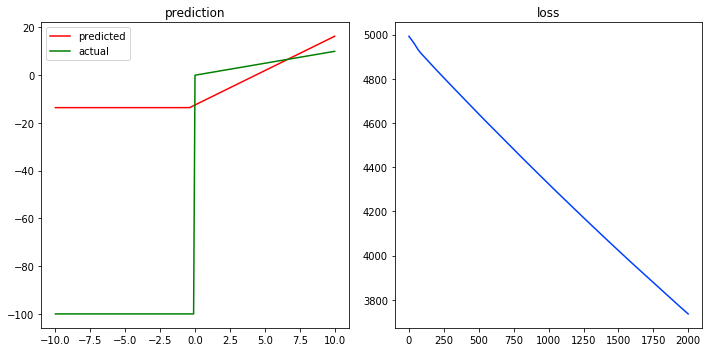

In [6]:
# adamのパラメータをデフォルトにした場合．
input_t = layers.Input(shape=(1,))
x = layers.Dense(2, activation='relu')(input_t)  # 2 newron
output_t = layers.Dense(1, activation='linear')(x)

model = Model([input_t], [output_t])

#model.summary()

model.compile(optimizer=optimizers.adam(), loss='mse')  # default
history = model.fit(X, Y, epochs=2000, verbose=0)
print('final loss = ', model.evaluate(X, Y, verbose=0))
    
show_result(X, Y, model.predict(X), history)

---
## ニューロン数を増やした場合の挙動
ニューロン数を増やした場合に，デフォルト設定で学習可能となるかを検証する．  
尚，データ点数が201であることから，学習パラメータ数は100程度に抑えるように設定している．

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                64        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 33        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
final loss =  37.50958602426954


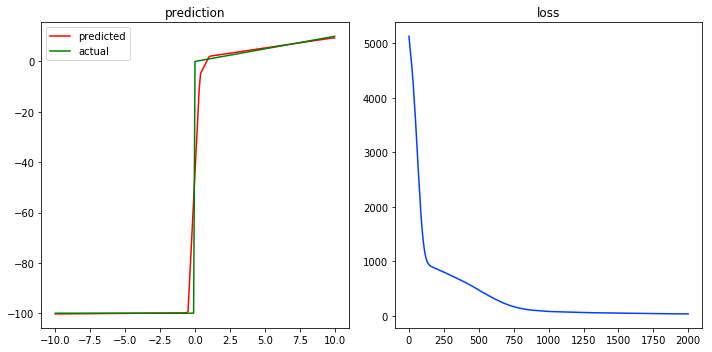

In [7]:
# 1層の場合
input_t = layers.Input(shape=(1,))
x = layers.Dense(32, activation='relu')(input_t)  # 2 newron
output_t = layers.Dense(1, activation='linear')(x)

model = Model([input_t], [output_t])

model.summary()

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, Y, epochs=2000, verbose=0)
print('final loss = ', model.evaluate(X, Y, verbose=0))

show_result(X, Y, model.predict(X), history)

上に示すように，学習可能である．また何度か試した限りでは結果も安定している．

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 8)                 16        
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
final loss =  0.10677187890741066


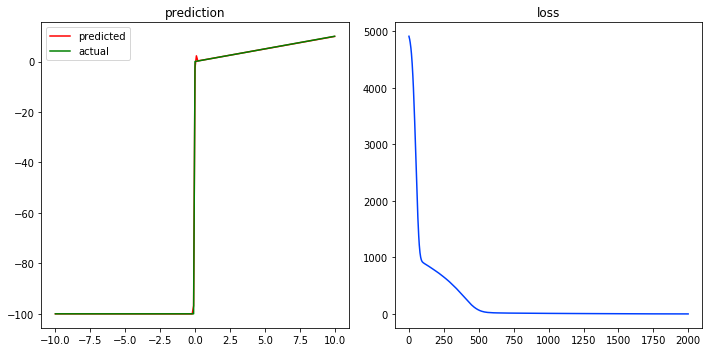

In [8]:
# 2層の場合
input_t = layers.Input(shape=(1,))
x = layers.Dense(8, activation='relu')(input_t)  # 2 newron
x = layers.Dense(8, activation='relu')(x)  # 2 newron
output_t = layers.Dense(1, activation='linear')(x)

model = Model([input_t], [output_t])

model.summary()

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, Y, epochs=2000, verbose=0)
print('final loss = ', model.evaluate(X, Y, verbose=0))

show_result(X, Y, model.predict(X), history)

2層の場合も同様に安定した結果が得られる．

---
## 4. 活性化関数をシグモイド関数に代えた場合
上述の設定を，活性化関数をシグモイド関数に代えて試してみる．  
尚，シグモイド関数は出力が飽和するため，2つのニューロンで表現することは困難と考え，検証しない．

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 33        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
final loss =  28.970489767653433


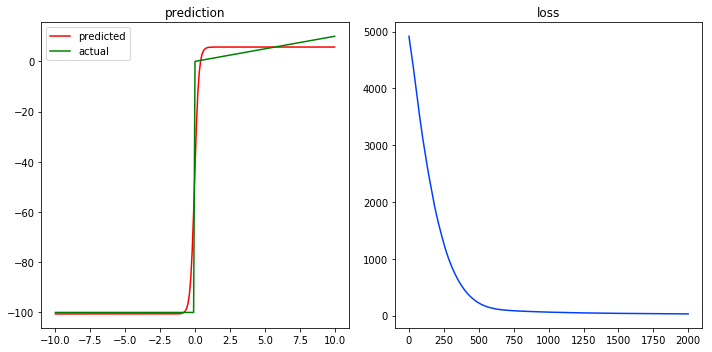

In [9]:
# 1層で活性化関数をシグモイド関数に代えた場合
input_t = layers.Input(shape=(1,))
x = layers.Dense(32, activation='sigmoid')(input_t)  # 2 newron
output_t = layers.Dense(1, activation='linear')(x)

model = Model([input_t], [output_t])

model.summary()

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, Y, epochs=2000, verbose=0)
print('final loss = ', model.evaluate(X, Y, verbose=0))

show_result(X, Y, model.predict(X), history)

誤差はあまり大きくないが，xが正の場合の単調増加を表現できていないので，利用できないと考えられる．

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_12 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
final loss =  94.79976253604414


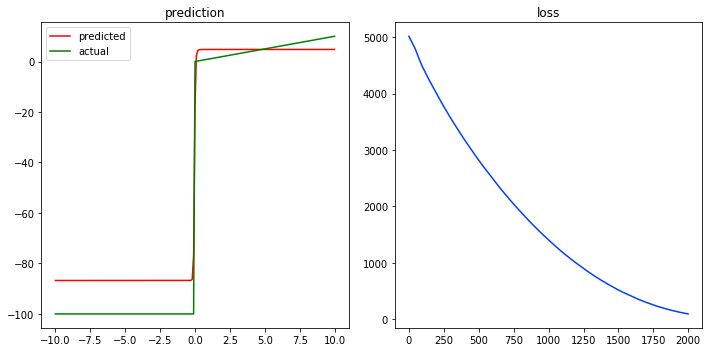

In [10]:
# 2層で活性化関数をシグモイド関数に代えた場合
input_t = layers.Input(shape=(1,))
x = layers.Dense(8, activation='sigmoid')(input_t)  # 2 newron
x = layers.Dense(8, activation='sigmoid')(x)  # 2 newron
output_t = layers.Dense(1, activation='linear')(x)

model = Model([input_t], [output_t])

model.summary()

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, Y, epochs=2000, verbose=0)
print('final loss = ', model.evaluate(X, Y, verbose=0))

show_result(X, Y, model.predict(X), history)

こちらも上と同様に利用できないと考えられる．

---
## 4. 他の関数〜例えばsin関数の場合
比較として，sin関数をどの程度近似できるかを確認する．

[]

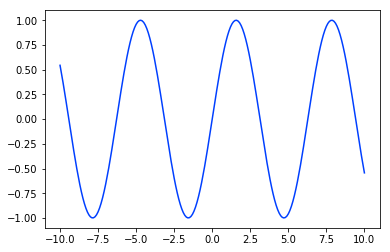

In [11]:
Y = np.sin(X)
plt.plot(X, Y)
plt.plot()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                64        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
final loss =  0.31707297806716084


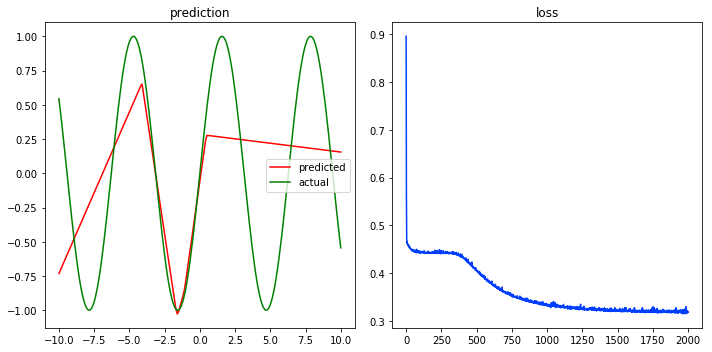

In [12]:
# 1層の場合
input_t = layers.Input(shape=(1,))
x = layers.Dense(32, activation='relu')(input_t)  # 2 newron
output_t = layers.Dense(1, activation='linear')(x)

model = Model([input_t], [output_t])

model.summary()

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, Y, epochs=2000, verbose=0)
print('final loss = ', model.evaluate(X, Y, verbose=0))

show_result(X, Y, model.predict(X), history)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 9         
Total params: 97
Trainable params: 97
Non-trainable params: 0
_________________________________________________________________
final loss =  0.09431793404956214


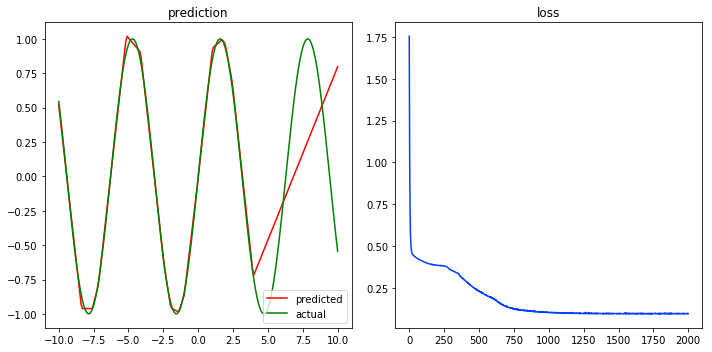

In [13]:
# 2層の場合
input_t = layers.Input(shape=(1,))
x = layers.Dense(8, activation='relu')(input_t)  # 2 newron
x = layers.Dense(8, activation='relu')(x)  # 2 newron
output_t = layers.Dense(1, activation='linear')(x)

model = Model([input_t], [output_t])

model.summary()

model.compile(optimizer='adam', loss='mse')
history = model.fit(X, Y, epochs=2000, verbose=0)
print('final loss = ', model.evaluate(X, Y, verbose=0))

show_result(X, Y, model.predict(X), history)

---
## 5. 結論
- ここでは示していないが，データ数を増やしても短いエポック数でフィットは良くなる傾向があった．但し，データ数を増やすと同じエポック数でもパラメタ更新回数が増えるのが主要因であると思われる（未検証）．Kerasのデフォルトは32であるため，201/32*2000~10000回程度の更新に相当する．
- 見た目にはかなり単純な関数だが，それなりのエポック数・オプティマイザの調整を行わないと，あまりいい結果は得られないようだ．
- 少なくとも価値関数の近似にシグモイド活性を用いるのは止めた方が良いだろう．